In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, to_hex
import seaborn as sns
import scanpy as sc
import anndata as ad
from scipy import sparse
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set scanpy settings
sc.settings.verbosity = 3  # verbosity level

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
adata = ad.read_h5ad('colon_adata.h5ad')

In [3]:
print(adata)

AnnData object with n_obs × n_vars = 447722 × 19244
    obs: 'fov', 'RNA_RNA.QC.Module_Cell.Typing.InSituType.1_1_clusters', 'RNA_RNA.QC.Module_Cell.Typing.InSituType.1_1_posterior_probability', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.G', 'Max.G', 'Mean.Membrane', 'Max.Membrane', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'SplitRatioToLocal', 'NucArea', 'NucAspectRatio', 'Circularity', 'Eccentricity', 'Perimeter', 'Solidity', 'cell_id', 'assay_type', 'version', 'Run_Tissue_name', 'Panel', 'cellSegmentationSetId', 'cellSegmentationSetName', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'median_RNA', 'RNA_quantile_0.75', 'RNA_quantile_0.8', 'RNA_quantile_0.85', 'RNA_quantile_0.9', 'RNA_quantile_0.95', 'RNA_quantile_0.99', 'nCount_RNA', 'nFeature_RNA', 'median_negprobes', 'negprobes_quantile_0.75', 'negprobes_quantile_0.8', 'negprobes_quantile_0.85', 'negprobes_qua

## 1. Quality control overview


In [4]:
print({"nCount_RNA", "nFeature_RNA", "Area", "Area.um2", "propNegative"} <= set(adata.obs.columns))
print(adata.obs[["nCount_RNA", "nFeature_RNA", "Area", "Area.um2", "propNegative"]].describe().T)

True
                 count         mean          std         min          25%  \
nCount_RNA    447722.0   500.297120   498.824737    5.000000   154.000000   
nFeature_RNA  447722.0   374.773522   361.073803    2.000000   117.000000   
Area          447722.0  5718.743975  2936.556563  672.000000  3642.000000   
Area.um2      447722.0    82.735961    42.484649    9.722164    52.690656   
propNegative  447722.0     0.000520     0.002406    0.000000     0.000000   

                      50%          75%           max  
nCount_RNA     352.000000   690.000000  15052.000000  
nFeature_RNA   267.000000   522.000000   7965.000000  
Area          5142.000000  7130.000000  59114.000000  
Area.um2        74.391914   103.153316    855.232134  
propNegative     0.000000     0.000000      0.166667  


### QC distribution plots
We visualize the existing `nCount_RNA`, `nFeature_RNA`, and `propNegative` columns before applying hard thresholds.


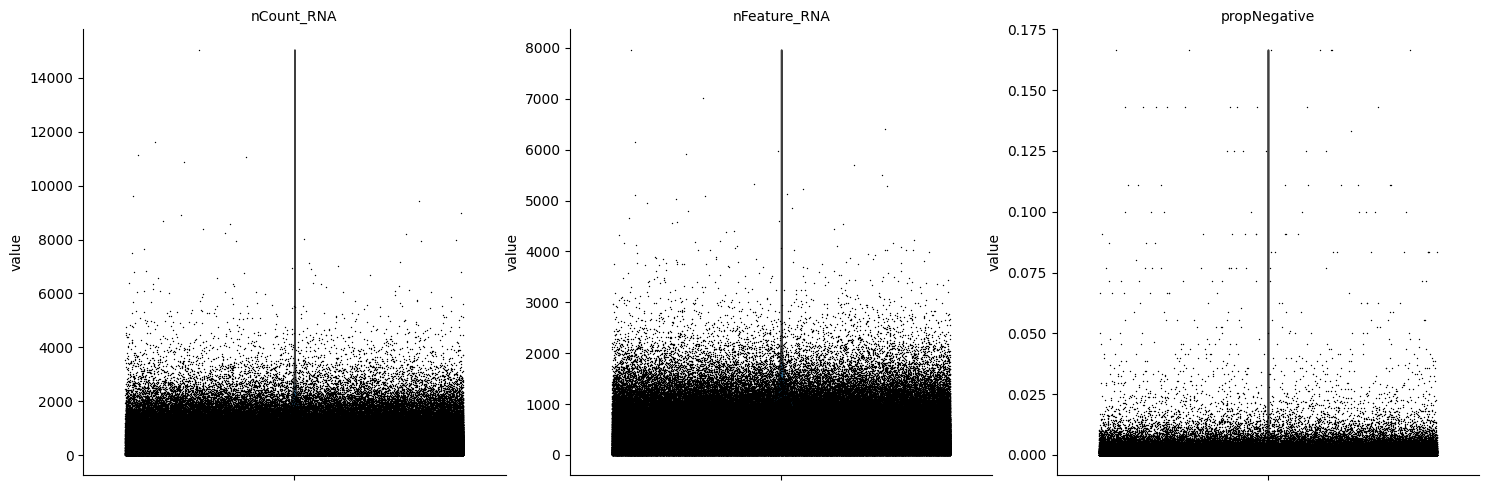

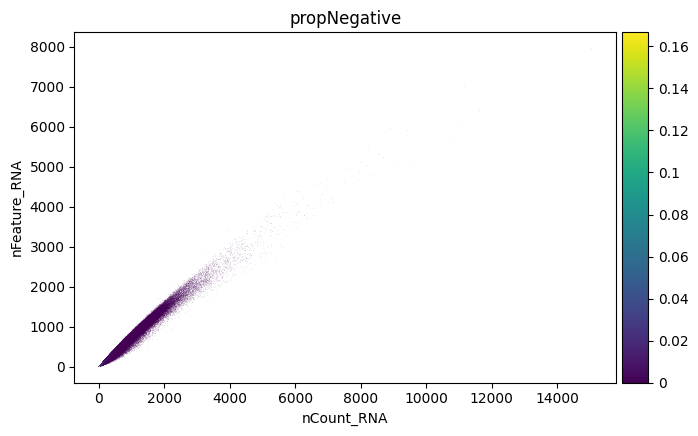

In [5]:
qc_plot_cols = ["nCount_RNA", "nFeature_RNA", "propNegative"]
sc.pl.violin(
    adata,
    keys=qc_plot_cols,
    jitter=0.4,
    multi_panel=True,
    rotation=45,
    show=False,
)
plt.show()

sc.pl.scatter(
    adata,
    x="nCount_RNA",
    y="nFeature_RNA",
    color="propNegative",
    show=False,
)
plt.show()


## 2. Basic QC thresholds
We remove cells with extremely low counts, low detected genes, or excessive negative-probe fractions.


In [6]:
min_counts = adata.obs["nCount_RNA"].quantile(0.05)
min_features = adata.obs["nFeature_RNA"].quantile(0.05)

qc_mask = (
    (adata.obs["nCount_RNA"] >= min_counts)
    & (adata.obs["nFeature_RNA"] >= min_features)
)

print(f"Cells before filtering: {adata.n_obs:,}")
adata = adata[qc_mask].copy()
print(f"Cells after filtering: {adata.n_obs:,}")


Cells before filtering: 447,722
Cells after filtering: 424,423


## 3. Normalization & log transform
Normalize to a fixed library size, then log-transform counts.


In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


## 4. Highly variable genes and scaling


In [8]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=3000,
)

adata = adata[:, adata.var["highly_variable"]].copy()
sc.pp.scale(adata, zero_center=True, max_value=10)

print(f"Using {adata.n_vars} highly variable genes")

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
Using 3000 highly variable genes


## 5. Dimensionality reduction


In [9]:
from sklearn.decomposition import PCA

sample_size = min(100000, adata.n_obs)
rng = np.random.default_rng(0)
sample_idx = rng.choice(adata.n_obs, sample_size, replace=False)
adata_sample = adata[sample_idx].copy()

print(f"Fitting PCA on {adata_sample.n_obs:,} cells (subset)")
pca_model = PCA(n_components=50, svd_solver="auto", random_state=0)
pca_model.fit(adata_sample.X)

Fitting PCA on 100,000 cells (subset)


PCA(n_components=50, random_state=0)

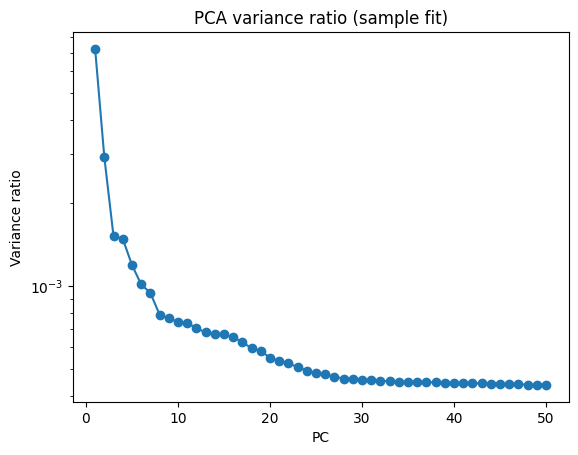

In [10]:
adata.obsm["X_pca"] = pca_model.transform(adata.X)
adata.varm["PCs"] = pca_model.components_.T
adata.uns["pca"] = {
    "variance": pca_model.explained_variance_,
    "variance_ratio": pca_model.explained_variance_ratio_,
    "params": {"n_comps": 50, "sample_size": sample_size},
}

plt.figure()
plt.plot(np.arange(1, 51), pca_model.explained_variance_ratio_, marker="o")
plt.xlabel("PC")
plt.ylabel("Variance ratio")
plt.title("PCA variance ratio (sample fit)")
plt.yscale("log")
plt.show()

## 6. Neighborhood graph and clustering


In [11]:
sc.pp.neighbors(
    adata,
    n_neighbors=15,
    n_pcs=15,
)

sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.8, key_added="leiden")


computing neighbors
    using 'X_pca' with n_pcs = 15


Python(7190) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:49)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:04:19)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (1:08:58)


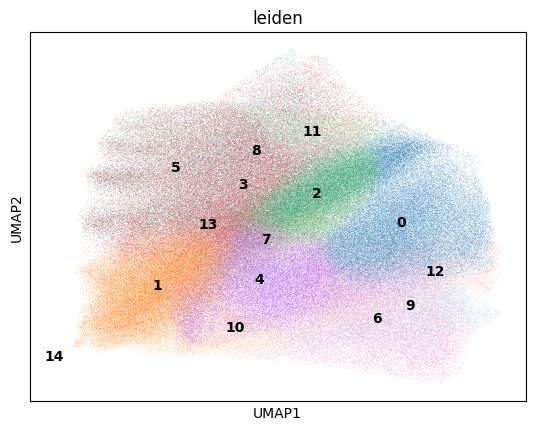

In [12]:
sc.pl.umap(adata, color="leiden", legend_loc="on data", show=False)
plt.show()

## 7. Marker detection


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:03:46)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


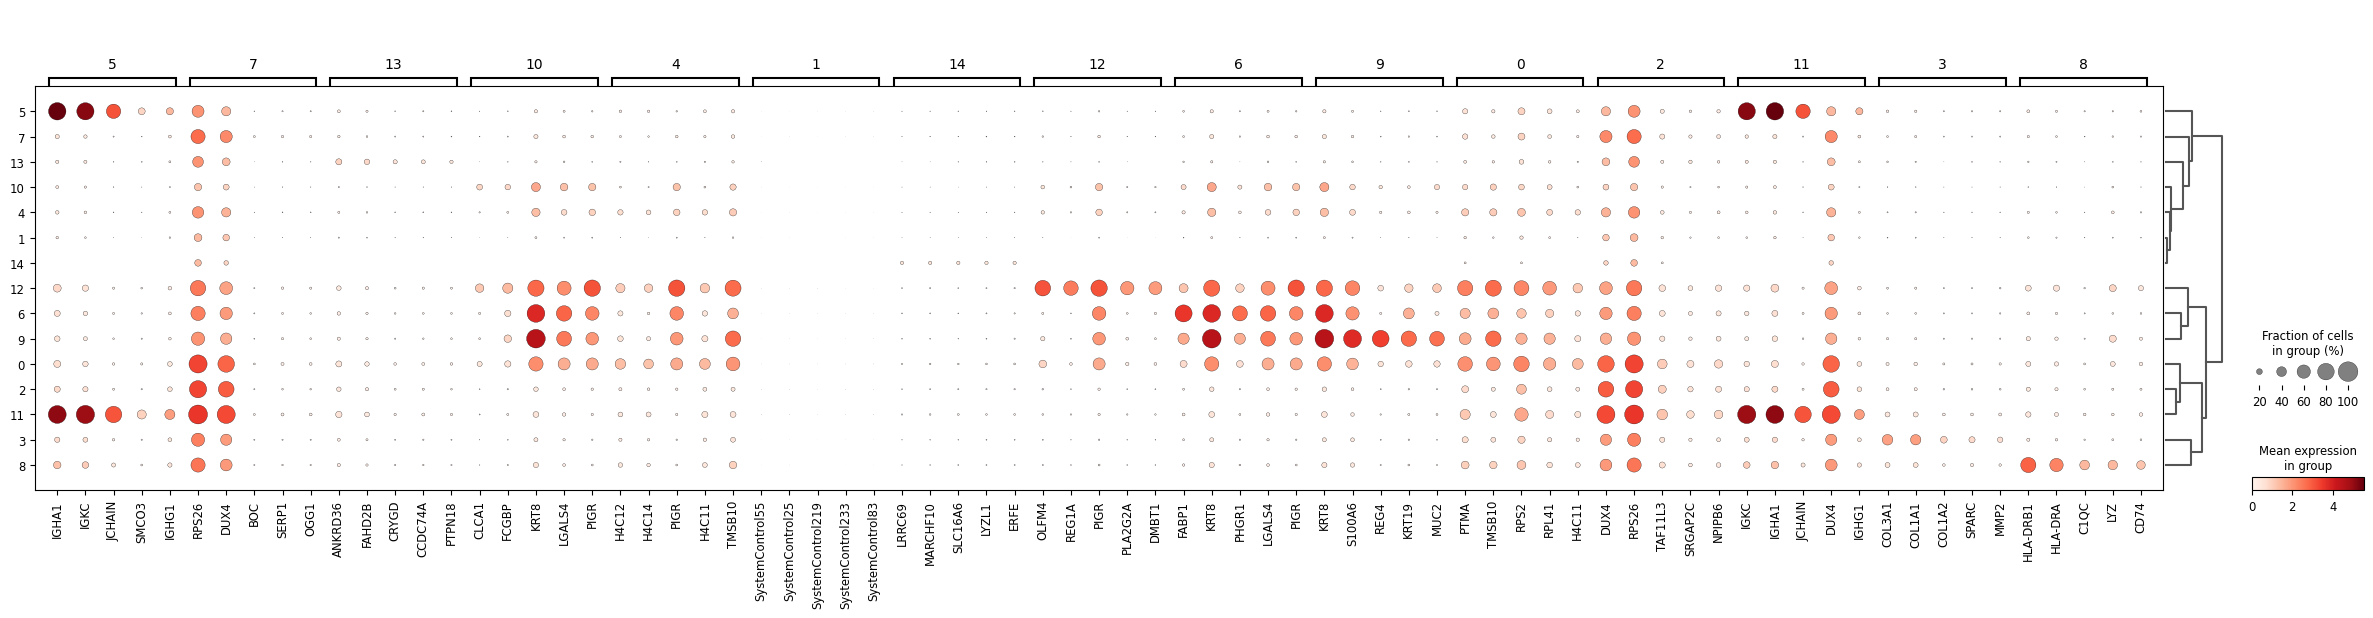

In [13]:
sc.tl.rank_genes_groups(
    adata,
    groupby="leiden",
    method="wilcoxon",
)

sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=5,
    groupby="leiden",
    show=False,
)
plt.show()


## 8. Export top-marker summaries
We capture the top 20 markers per Leiden cluster, save annotated dot plots, and write a presence/absence table for downstream review.


In [14]:
output_dir = Path("leiden_markers")
dotplot_dir = output_dir / "dotplots"
output_dir.mkdir(exist_ok=True)
dotplot_dir.mkdir(exist_ok=True)

clusters = adata.obs["leiden"].astype("category").cat.categories
print(f"Preparing top markers for {len(clusters)} clusters -> {output_dir.resolve()}")


Preparing top markers for 15 clusters -> /Users/brunondibambwayeroy/Documents/R Projects/YALE DATA/leiden_markers


In [15]:
sc.tl.dendrogram(adata, groupby="leiden")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


In [16]:
top_n = 20
cluster_to_genes = {}
all_markers = set()

for cluster in clusters:
    df = sc.get.rank_genes_groups_df(adata, group=str(cluster))
    top_genes = df.sort_values("logfoldchanges", ascending=False).head(top_n)["names"].tolist()
    cluster_to_genes[cluster] = top_genes
    all_markers.update(top_genes)

marker_table = pd.DataFrame("no", index=sorted(all_markers), columns=clusters)
for cluster, genes in cluster_to_genes.items():
    marker_table.loc[genes, cluster] = "yes"

csv_path = output_dir / "leiden_top20_markers.csv"
marker_table.to_csv(csv_path)
print(f"Saved marker presence table to {csv_path}")


Saved marker presence table to leiden_markers/leiden_top20_markers.csv


In [17]:
for cluster in clusters:
    title = f"Leiden {cluster} — top {top_n} markers"
    sc.pl.rank_genes_groups_dotplot(
        adata,
        groupby="leiden",
        groups=[cluster],
        n_genes=top_n,
        dendrogram=False,
        figsize=(6, 6),
        log=True,
        show=False,
        colorbar_title="avg expr",
    )
    fig = plt.gcf()
    fig.suptitle(title, y=1.02)
    plot_path = dotplot_dir / f"cluster_{cluster}_top{top_n}_dotplot.png"
    fig.savefig(plot_path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved {plot_path}")

Saved leiden_markers/dotplots/cluster_0_top20_dotplot.png
Saved leiden_markers/dotplots/cluster_1_top20_dotplot.png
Saved leiden_markers/dotplots/cluster_2_top20_dotplot.png
Saved leiden_markers/dotplots/cluster_3_top20_dotplot.png
Saved leiden_markers/dotplots/cluster_4_top20_dotplot.png
Saved leiden_markers/dotplots/cluster_5_top20_dotplot.png
Saved leiden_markers/dotplots/cluster_6_top20_dotplot.png
Saved leiden_markers/dotplots/cluster_7_top20_dotplot.png
Saved leiden_markers/dotplots/cluster_8_top20_dotplot.png
Saved leiden_markers/dotplots/cluster_9_top20_dotplot.png
Saved leiden_markers/dotplots/cluster_10_top20_dotplot.png
Saved leiden_markers/dotplots/cluster_11_top20_dotplot.png
Saved leiden_markers/dotplots/cluster_12_top20_dotplot.png
Saved leiden_markers/dotplots/cluster_13_top20_dotplot.png
Saved leiden_markers/dotplots/cluster_14_top20_dotplot.png


## 9. Feature plots for top Leiden markers
Using the previously derived top-20 markers per cluster, we select the most broadly significant genes and render UMAP feature plots with a custom colormap.


In [21]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["blue", "green", "yellow", "red"]
custom_cmap = LinearSegmentedColormap.from_list(
    "BlueGreenYellowRed",
    colors,
    N=256,
)

feature_plot_root = Path("feature_plots")
feature_plot_root.mkdir(exist_ok=True)
print(f"Feature plots will be saved to {feature_plot_root.resolve()}")


Feature plots will be saved to /Users/brunondibambwayeroy/Documents/R Projects/YALE DATA/feature_plots


In [22]:
cluster_feature_dir = feature_plot_root / "per_cluster"
cluster_feature_dir.mkdir(exist_ok=True)

n_markers_per_cluster = 10
plots_created = 0

for cluster in clusters:
    genes = cluster_to_genes.get(cluster, [])[:n_markers_per_cluster]
    if not genes:
        continue

    cluster_dir = cluster_feature_dir / f"cluster_{cluster}"
    cluster_dir.mkdir(exist_ok=True)

    for gene in genes:
        if gene not in adata.var_names:
            continue

        sc.pl.umap(
            adata,
            color=gene,
            cmap=custom_cmap,
            size=1.5,
            vmax="p99",
            title=f"Cluster {cluster} marker: {gene}",
            show=False,
        )
        fig = plt.gcf()
        fig.savefig(
            cluster_dir / f"{gene}_feature.png",
            dpi=200,
            bbox_inches="tight",
        )
        plt.close(fig)
        plots_created += 1

print(
    f"Saved {plots_created} feature plots (top {n_markers_per_cluster} markers per cluster) to {cluster_feature_dir.resolve()}"
)


Saved 132 feature plots (top 10 markers per cluster) to /Users/brunondibambwayeroy/Documents/R Projects/YALE DATA/feature_plots/per_cluster


## 10. UMAP colored by vendor InSituType clusters


In [ ]:
cluster_col = "RNA_RNA.QC.Module_Cell.Typing.InSituType.1_1_clusters"
cluster_categories = (
    adata.obs[cluster_col]
    .astype("category")
    .cat.categories
)

cluster_palette = sns.color_palette("tab20", n_colors=max(len(cluster_categories), 1))
cluster_colors = [to_hex(color) for color in cluster_palette]
cluster_color_lookup = dict(zip(cluster_categories, cluster_colors))

umap_dir = Path("umap_plots")
umap_dir.mkdir(exist_ok=True)

sc.pl.umap(
    adata,
    color=cluster_col,
    palette=cluster_colors,
    legend_loc="right margin",
    size=1.5,
    title="UMAP colored by InSituType clusters",
    show=False,
)
fig = plt.gcf()
fig.savefig(umap_dir / "umap_insitutype_clusters.png", dpi=250, bbox_inches="tight")
plt.close(fig)

print(
    f"Saved InSituType-colored UMAP with {len(cluster_categories)} clusters to {umap_dir.resolve()}"
)

Saved InSituType-colored UMAP with 10 clusters to /Users/brunondibambwayeroy/Documents/R Projects/YALE DATA/umap_plots


## 11. FOV overlays with Leiden clusters


In [ ]:
leiden_plot_dir = Path("fov_leiden_plots")
leiden_plot_dir.mkdir(exist_ok=True)

leiden_palette = sns.color_palette("tab20", n_colors=max(len(clusters), 1))
leiden_color_lookup = {
    cluster: to_hex(color)
    for cluster, color in zip(clusters, leiden_palette)
}

poly = adata.uns.get("polygons")


def make_leiden_fov_plot(fov_id: int):
    adata_fov = adata[adata.obs["fov"] == fov_id].copy()
    if adata_fov.n_obs == 0:
        raise ValueError(f"FOV {fov_id} has no cells in the AnnData object.")

    x = adata_fov.obsm["spatial"][:, 0]
    y = adata_fov.obsm["spatial"][:, 1]

    cluster_series = adata_fov.obs["leiden"].astype("category").cat.remove_unused_categories()
    scatter_colors = cluster_series.map(leiden_color_lookup).astype(object).fillna("#333333")
    cell_to_cluster = cluster_series.to_dict()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    axes[0].scatter(x, y, s=4, c=scatter_colors)
    axes[0].set_title(f"FOV {fov_id} — Leiden scatter")
    axes[0].set_xlabel("CenterX_local_px")
    axes[0].set_ylabel("CenterY_local_px")
    axes[0].invert_yaxis()

    legend_handles = [
        mpatches.Patch(color=leiden_color_lookup[cat], label=str(cat))
        for cat in cluster_series.cat.categories
        if cat in leiden_color_lookup
    ]
    if legend_handles:
        axes[0].legend(
            handles=legend_handles,
            title="Leiden",
            loc="upper left",
            bbox_to_anchor=(1.02, 1.0),
            borderaxespad=0.0,
        )

    axes[1].set_title(f"FOV {fov_id} — Polygons")
    axes[1].set_xlabel("x_local_px")
    axes[1].set_ylabel("y_local_px")

    if poly is not None:
        poly_fov = poly[poly["fov"] == fov_id]
        for cell_label, df in poly_fov.groupby("cell"):
            cluster_label = cell_to_cluster.get(cell_label)
            color = leiden_color_lookup.get(cluster_label, "#777777")
            axes[1].plot(df["x_local_px"], df["y_local_px"], linewidth=0.5, color=color)
    else:
        axes[1].text(0.5, 0.5, "No polygon data", ha="center", va="center")

    axes[1].invert_yaxis()
    axes[1].set_aspect("equal", adjustable="box")
    axes[0].set_aspect("equal", adjustable="box")

    fig.suptitle(f"FOV {fov_id}: Leiden clusters & polygons", fontsize=14)
    fig.tight_layout()
    return fig


In [1]:
leiden_saved = []
for raw_fov in sorted(adata.obs["fov"].unique()):
    fov_id = int(raw_fov)
    fig = make_leiden_fov_plot(fov_id)
    out_path = leiden_plot_dir / f"fov_{fov_id:03d}_leiden.png"
    fig.savefig(out_path, dpi=250, bbox_inches="tight")
    plt.close(fig)
    leiden_saved.append(out_path)

print(f"Saved {len(leiden_saved)} Leiden FOV overlays to {leiden_plot_dir.resolve()}")

NameError: name 'adata' is not defined